--------------

### `Feature extraction from 200 WSI images (balanced set)`

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

## Import and Prepare Data

In [2]:
training_data = pd.read_csv('/root/ubc/train.csv')

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Select WSI images
non_tma_data_simple = training_data[training_data['is_tma'] == False]

# Sampling 40 images from each cancer type
balanced_data = non_tma_data_simple.groupby('label').sample(n=40, random_state=33)

# Adding a new column 'path' to the balanced dataset
balanced_data['path'] = balanced_data['image_id'].astype(str) + '.png'

# Displaying the updated DataFrame
balanced_data

,image_id,label,image_width,image_height,is_tma,path
53,5970,CC,27265,22900,False,5970.png
531,64824,CC,46589,19365,False,64824.png
19,1952,CC,33685,38053,False,1952.png
492,59515,CC,64700,36387,False,59515.png
462,54928,CC,36166,31487,False,54928.png
...,...,...,...,...,...,...
408,48550,MC,32431,25393,False,48550.png
332,39252,MC,48980,40700,False,39252.png
401,47431,MC,67495,46563,False,47431.png
534,65094,MC,55042,45080,False,65094.png


## Tile visualization

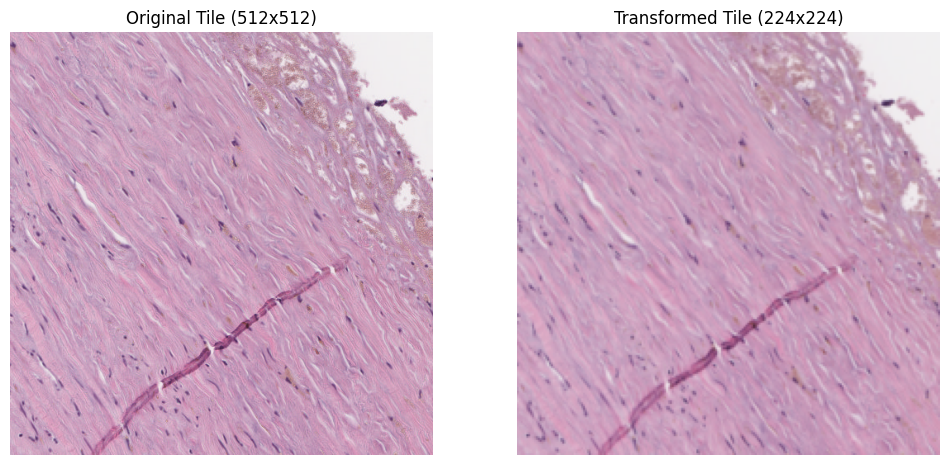

In [1]:
import zipfile
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Define the path to the zip file and the image within it
zip_path = '/root/UBC-OCEAN.zip'  # Replace with the path to your zip file
image_inside_zip = 'train_images/51215.png'  # Replace with the path inside the zip

# Temporary directory to extract the image
temp_dir = '/root/temp/'

# Ensure the temporary directory exists
os.makedirs(temp_dir, exist_ok=True)

# Extract the image from the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(image_inside_zip, temp_dir)

# Full path to the extracted image
image_path = os.path.join(temp_dir, image_inside_zip)

# Open the image and extract a 512x512 tile
with Image.open(image_path) as img:
    width, height = img.size

    # Calculate coordinates to crop the center tile
    left = (width/4 - 512) / 2
    top = (height/4 - 512) / 2
    right = (width/4 + 512) / 2
    bottom = (height/4 + 512) / 2

    tile = img.crop((left, top, right, bottom))

# Convert the PIL Image tile to a NumPy array for visualization
original_tile_np = np.array(tile)

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply transformations
transformed_tile = transform(tile)

# Convert the transformed tensor back to a PIL Image for visualization
# First, undo the normalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transformed_tile = transformed_tile.numpy().transpose((1, 2, 0))
transformed_tile = std * transformed_tile + mean
transformed_tile = np.clip(transformed_tile, 0, 1)

# Plotting the original and transformed tiles
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_tile_np)
plt.title('Original Tile (512x512)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_tile)
plt.title('Transformed Tile (224x224)')
plt.axis('off')

plt.show()

# Clean up: delete the extracted file and temp directory
os.remove(image_path)
os.rmdir(os.path.dirname(image_path))

## Feature Extraction

In [ ]:
import cv2
import timm
import torch
from torchvision import transforms
from PIL import Image, ImageFile
import zipfile
import os

# Assuming the ZIP file path and the root directory inside the ZIP
zip_path = '/root/UBC-OCEAN.zip'
zip_root_dir = 'train_images/'

# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet101', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.55, low_saturation_threshold=20):   # 55% tissue
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Function to process a patch of the image
def process_patch(patch, model, transform):
    if is_tissue_present(patch):
        features = extract_features(patch, model, transform)
        return features
    return None

# Define the size for the tiles
tile_size = 512

slide_features = {}

# Process each image, extract tiles, extract features, and store them
total_images = len(balanced_data)
for index, row in balanced_data.iterrows():
    #if index >= 2:
        # Stop after processing the first 50 images
       # break

    tile_features = [] # List to hold the features for the current image

    # Extracting image from ZIP
    image_name = row['path']  # Adjust based on your DataFrame structure
    image_path = os.path.join(zip_root_dir, image_name)

    # Print the current status
    print(f"Processing image {index + 1} of {total_images}: {image_path}")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extract(image_path, '/root/ubc_ocean/temp')
            extracted_image_path = os.path.join('/root/ubc_ocean/temp', image_path)

            with Image.open(extracted_image_path) as img:
                for y in range(0, img.height, tile_size):
                    for x in range(0, img.width, tile_size):
                        # Read the patch
                        patch = img.crop((x, y, x + tile_size, y + tile_size))
                        patch = np.array(patch)  # Convert PIL Image to NumPy array

                        # Process the patch
                        features = process_patch(patch, model, transform)
                        if features is not None:
                            tile_features.append(features)

            # Delete the extracted image to save space
            os.remove(extracted_image_path)

        # Store the extracted features and the label in the slide_features dictionary
        slide_features[image_name] = {
            'features': tile_features,
            'label': row[1]['label']
        }
    except Exception as e:
        print(f"Error processing image {image_name}: {e}")


### save features

In [ ]:
import pickle

with open('/root/ubc_ocean/anar/extracted-features/512px_resnet101_200.pkl', 'wb') as f:
    pickle.dump(slide_features, f)

### load features

In [ ]:
import pickle

with open('/root/ubc_ocean/anar/extracted-features/512px_resnet101_200.pkl', 'rb') as f:
    slide_features = pickle.load(f)